In [1]:
from itertools import pairwise

import arviz as az
import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import optax
import seaborn as sns
import tqdm
import xarray as xr
from flax import nnx
from jax import random
from jaxtyping import Array, ArrayLike, Float, Int
from numpyro.contrib.module import random_nnx_module
from numpyro.infer import SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.infer.svi import SVIRunResult, SVIState
from sklearn.datasets import make_moons
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

seed = 42
rng_key = random.PRNGKey(seed=seed)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

c:\Users\nisha\Projects\mediapipe_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


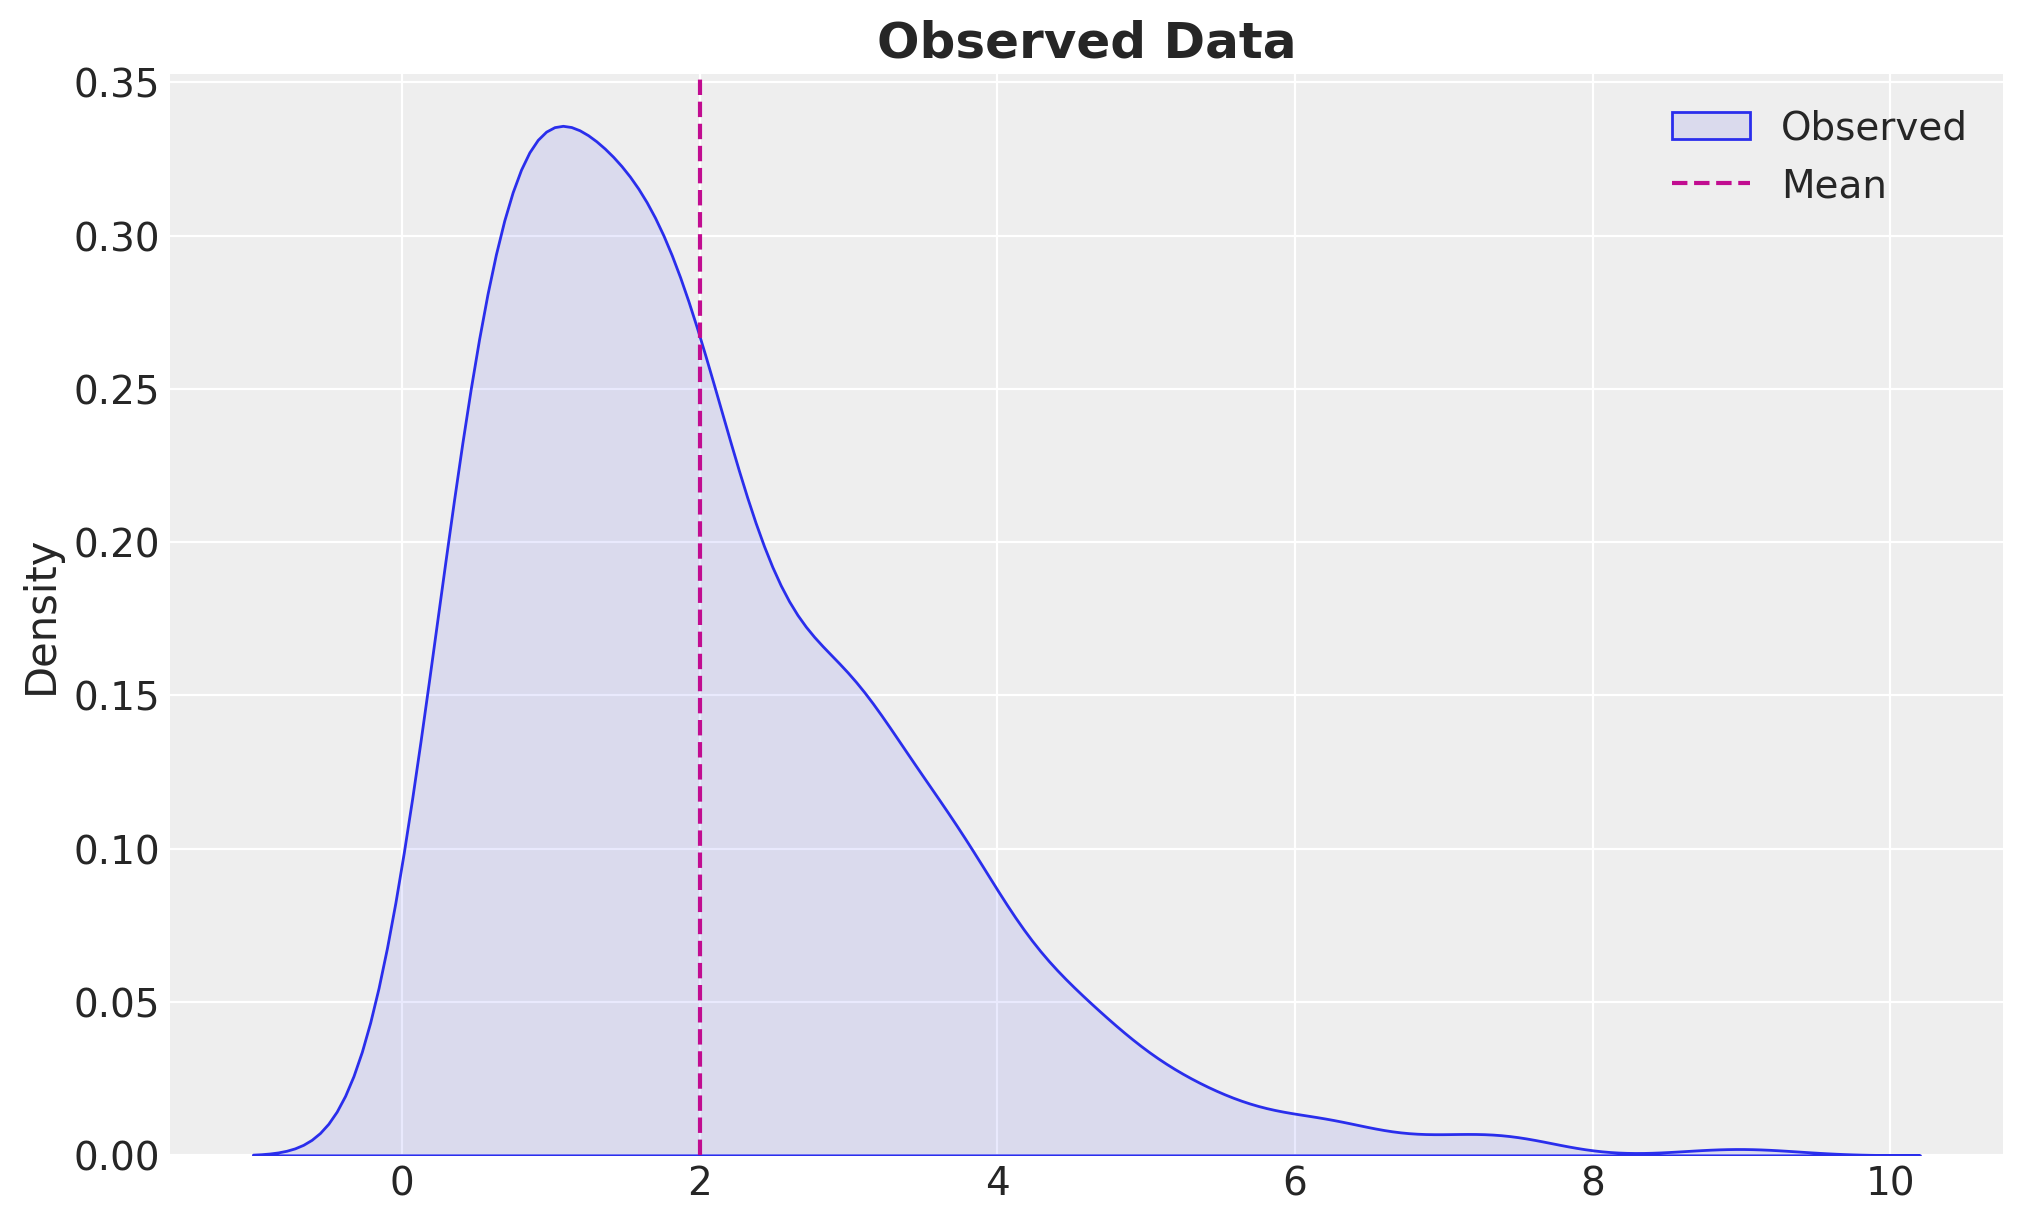

In [2]:
# Generate toy data samples from a Gamma distribution
rng_key, rng_subkey = random.split(rng_key)
concentration = 2.0
n_obs = 1_000
z = random.gamma(rng_subkey, a=concentration, shape=(n_obs,))

fig, ax = plt.subplots()
sns.kdeplot(z, fill=True, alpha=0.1, label="Observed", ax=ax)
ax.axvline(concentration / 1.0, color="C3", linestyle="--", label="Mean")
ax.legend()
ax.set_title("Observed Data", fontsize=18, fontweight="bold");

In [3]:
# Define the model
def model(z: jax.Array | None = None) -> None:
    # Set the prior for the concentration parameter (it has to be positive!)
    concentration = numpyro.sample("concentration", dist.HalfNormal(scale=1))
    rate = 1.0
    # Generate the data from the Gamma distribution
    numpyro.sample("z", dist.Gamma(concentration=concentration, rate=rate), obs=z)

In [4]:
# Define the guide
# It approximates the posterior distribution of the model parameters
# with a normal distribution
def guide(z: jax.Array | None = None) -> None:
    # Define the location and scale parameters of the normal distribution
    concentration_loc = numpyro.param("concentration_loc", init_value=0.5)
    # Define the scale parameter of the normal distribution
    # It has to be positive!
    concentration_scale = numpyro.param(
        "concentration_scale",
        init_value=0.1,
        constraint=dist.constraints.positive,
    )
    # Define the base distribution
    base_distribution = dist.Normal(loc=concentration_loc, scale=concentration_scale)
    # Define the transformed distribution
    # Observe that we are using the `ExpTransform` to transform the base distribution
    # as the concentration parameter has to be positive.
    transformed_distribution = dist.TransformedDistribution(
        base_distribution=base_distribution,
        transforms=dist.transforms.ExpTransform(),
    )
    # We need to make sure the guide has the same sample statements as the model
    # (for the distributions we want to infer)
    numpyro.sample("concentration", transformed_distribution)

In [5]:
# Define the loss function (ELBO)
loss = Trace_ELBO(num_particles=10)
# Define the optimizer
optimizer = optax.adam(learning_rate=0.005)
# Define the SVI algorithm
svi = SVI(model=model, guide=guide, optim=optimizer, loss=loss)

100%|██████████| 1000/1000 [00:02<00:00, 392.35it/s, init loss: 1647.7777, avg. loss [951-1000]: 1590.6809]


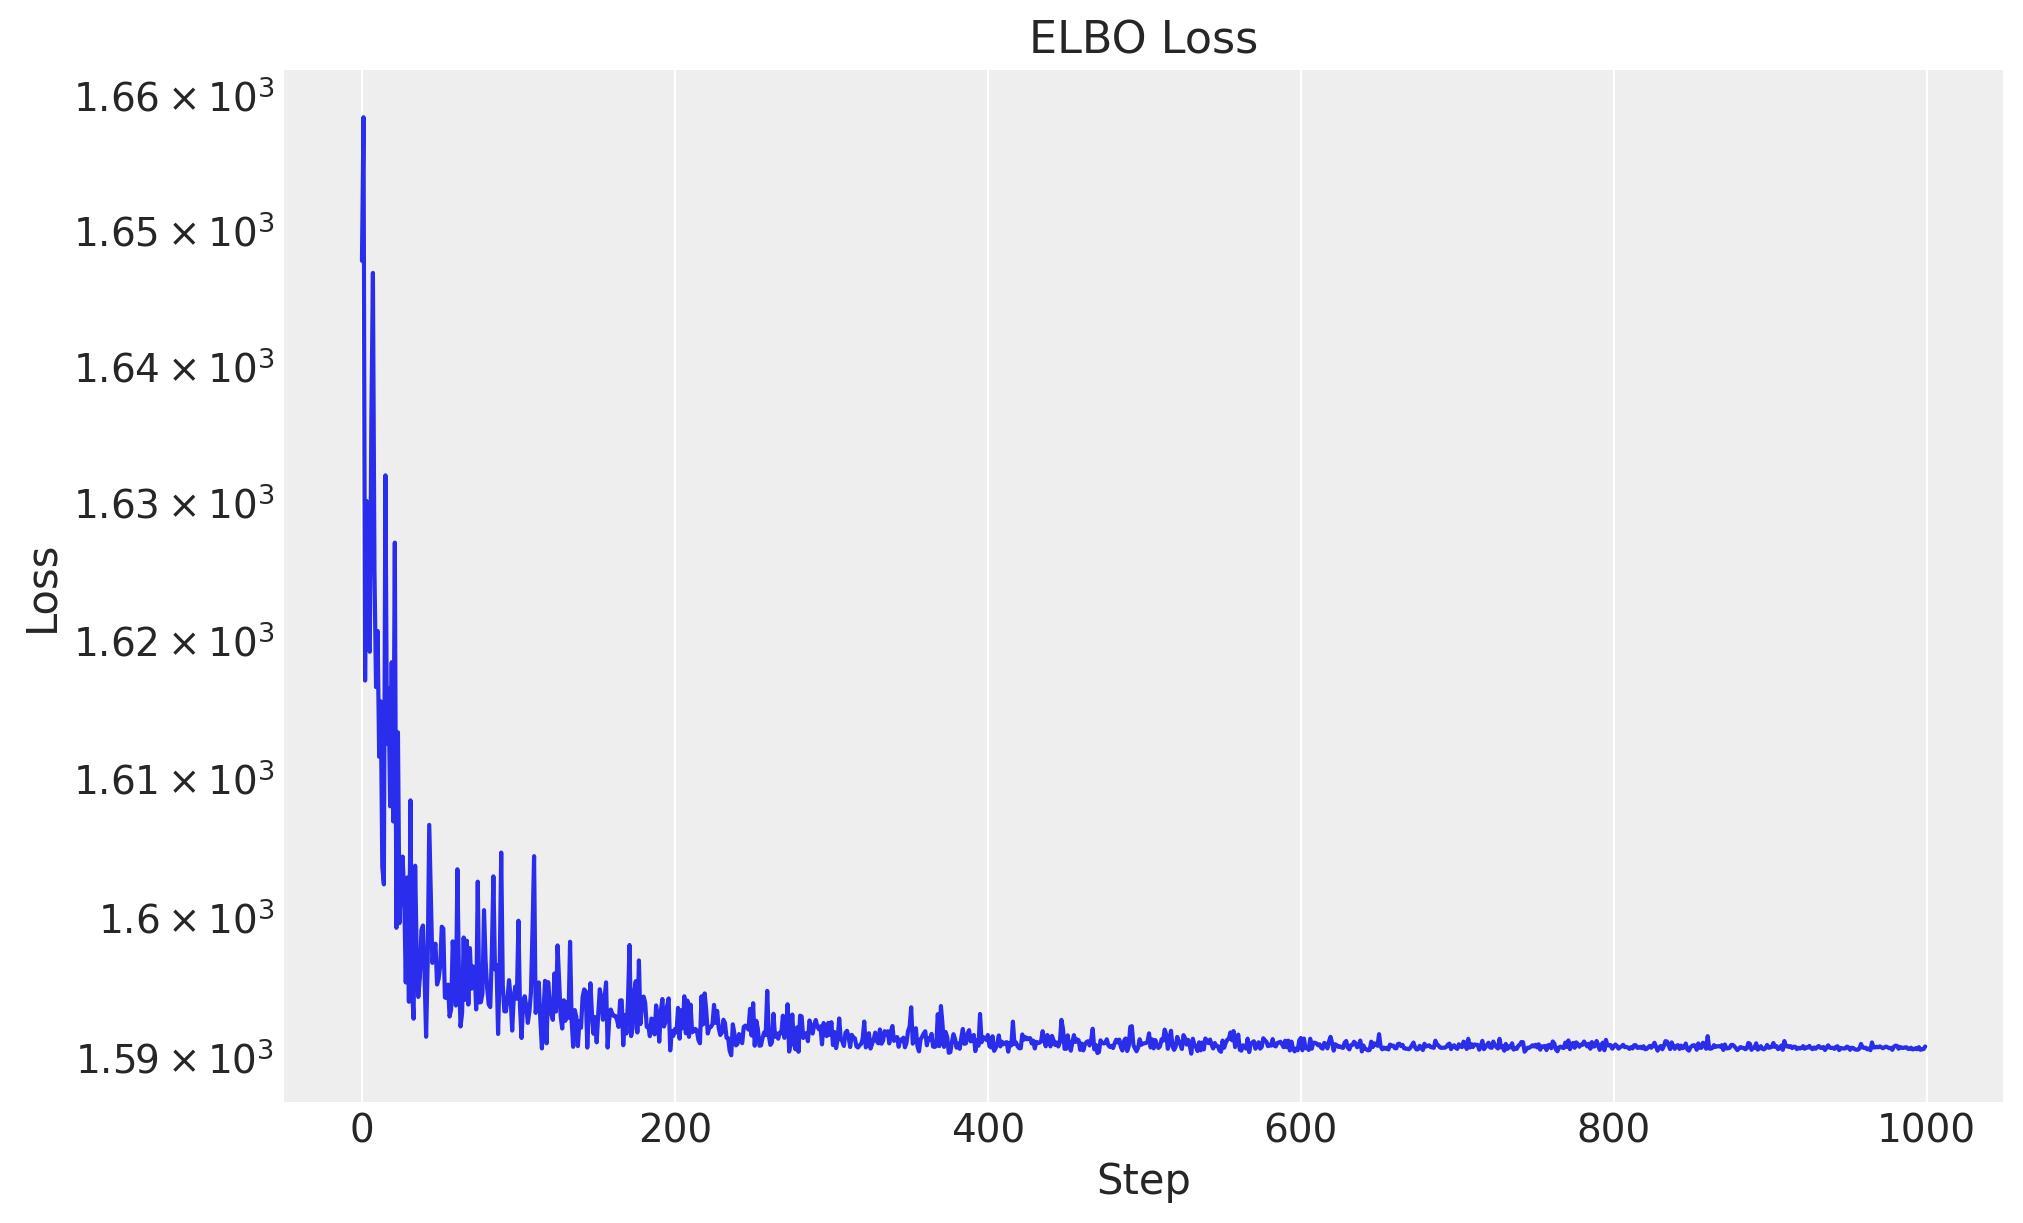

In [6]:
# Run the SVI algorithm
rng_key, rng_subkey = random.split(rng_key)
svi_result = svi.run(rng_subkey, num_steps=1_000, z=z, progress_bar=True)

fig, ax = plt.subplots()
ax.plot(svi_result.losses)
ax.set(yscale="log")
ax.set(title="ELBO Loss", xlabel="Step", ylabel="Loss");

In [7]:
svi_result.params

{'concentration_loc': Array(0.68632126, dtype=float32),
 'concentration_scale': Array(0.02304399, dtype=float32)}

In [9]:
rng_key, rng_subkey = random.split(rng_key)

# Sample from a normal distribution from the learned parameters
# in the constrained space through the exponential function.
concentration_posterior_samples = jnp.exp(
    svi_result.params["concentration_loc"]
    + random.normal(rng_subkey, shape=(4_000,))
    * svi_result.params["concentration_scale"]
)
rng_key, rng_subkey = random.split(rng_key)
posterior_samples = random.gamma(rng_subkey, a=concentration_posterior_samples)

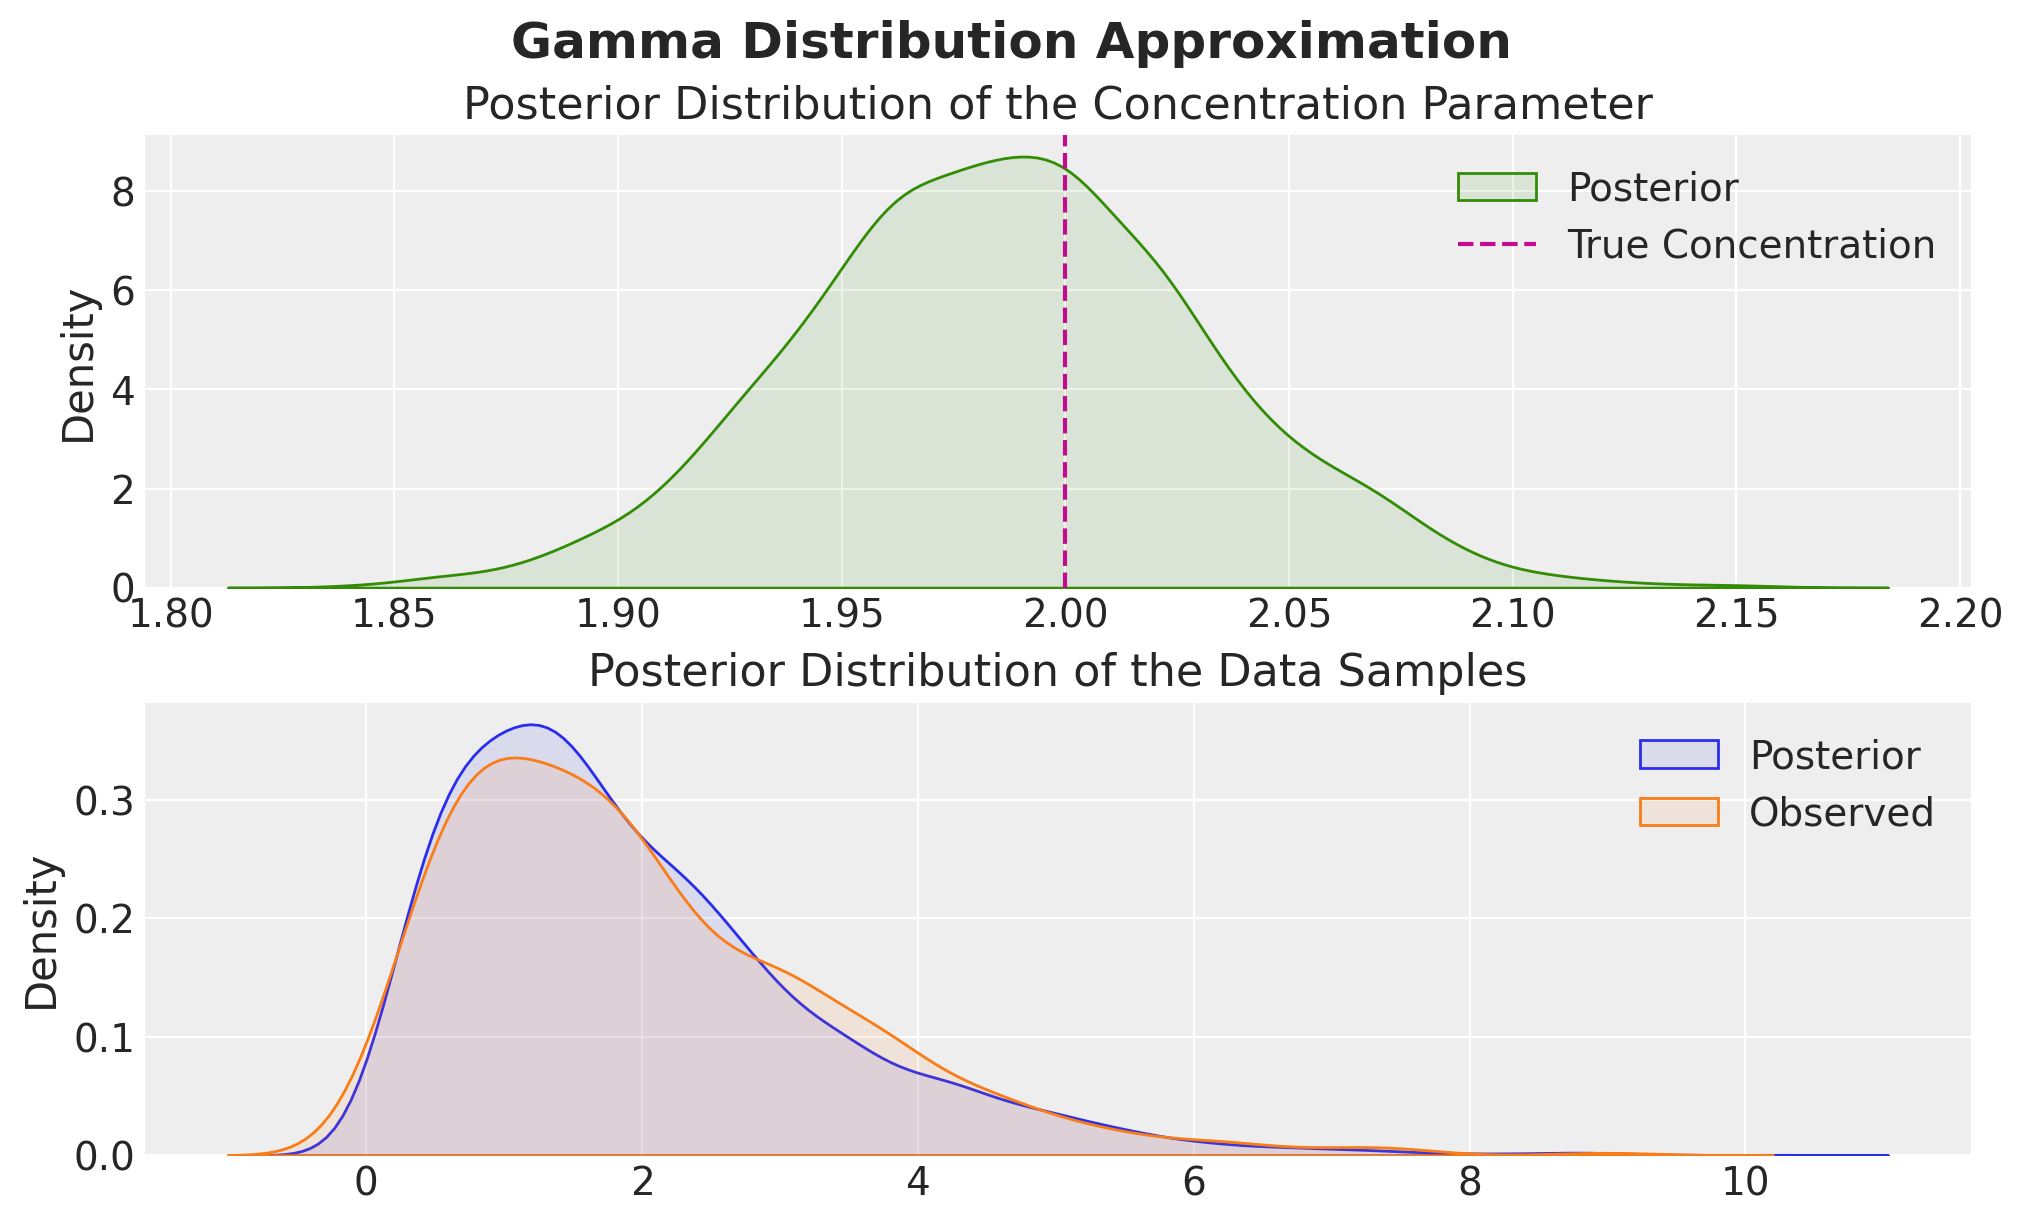

In [10]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    sharex=False,
    sharey=False,
    figsize=(10, 6),
    layout="constrained",
)

sns.kdeplot(
    concentration_posterior_samples,
    fill=True,
    alpha=0.1,
    color="C2",
    label="Posterior",
    ax=ax[0],
)
ax[0].axvline(concentration, color="C3", linestyle="--", label="True Concentration")
ax[0].legend()
ax[0].set(title="Posterior Distribution of the Concentration Parameter")

sns.kdeplot(posterior_samples, fill=True, alpha=0.1, label="Posterior", ax=ax[1])
sns.kdeplot(z, fill=True, alpha=0.1, label="Observed", ax=ax[1])
ax[1].legend()
ax[1].set(title="Posterior Distribution of the Data Samples")
fig.suptitle("Gamma Distribution Approximation", fontsize=18, fontweight="bold");

In [11]:
# This time we use an AutoNormal guide
guide = AutoNormal(model)

# Define the loss function (ELBO)
loss = Trace_ELBO(num_particles=10)
# Define the optimizer
optimizer = optax.adam(learning_rate=0.005)
# Define the SVI algorithm
svi = SVI(model=model, guide=guide, optim=optimizer, loss=loss)

# Run the SVI algorithm
rng_key, rng_subkey = random.split(rng_key)
svi_result = svi.run(rng_subkey, num_steps=1_000, z=z, progress_bar=False)

# Generate posterior samples from the model (forward pass)
posterior = Predictive(
    model=model,
    guide=guide,
    params=svi_result.params,
    num_samples=1_000,
    return_sites=["concentration", "z"],
)
rng_key, rng_subkey = random.split(rng_key)
posterior_samples = posterior(rng_key, z=z)

# Store the posterior samples in an ArviZ InferenceData object
idata = az.from_dict(
    posterior={
        k: np.expand_dims(a=np.asarray(v), axis=0) for k, v in posterior_samples.items()
    },
    coords={"obs_idx": range(len(z))},
    dims={"z": ["obs_idx"]},
)

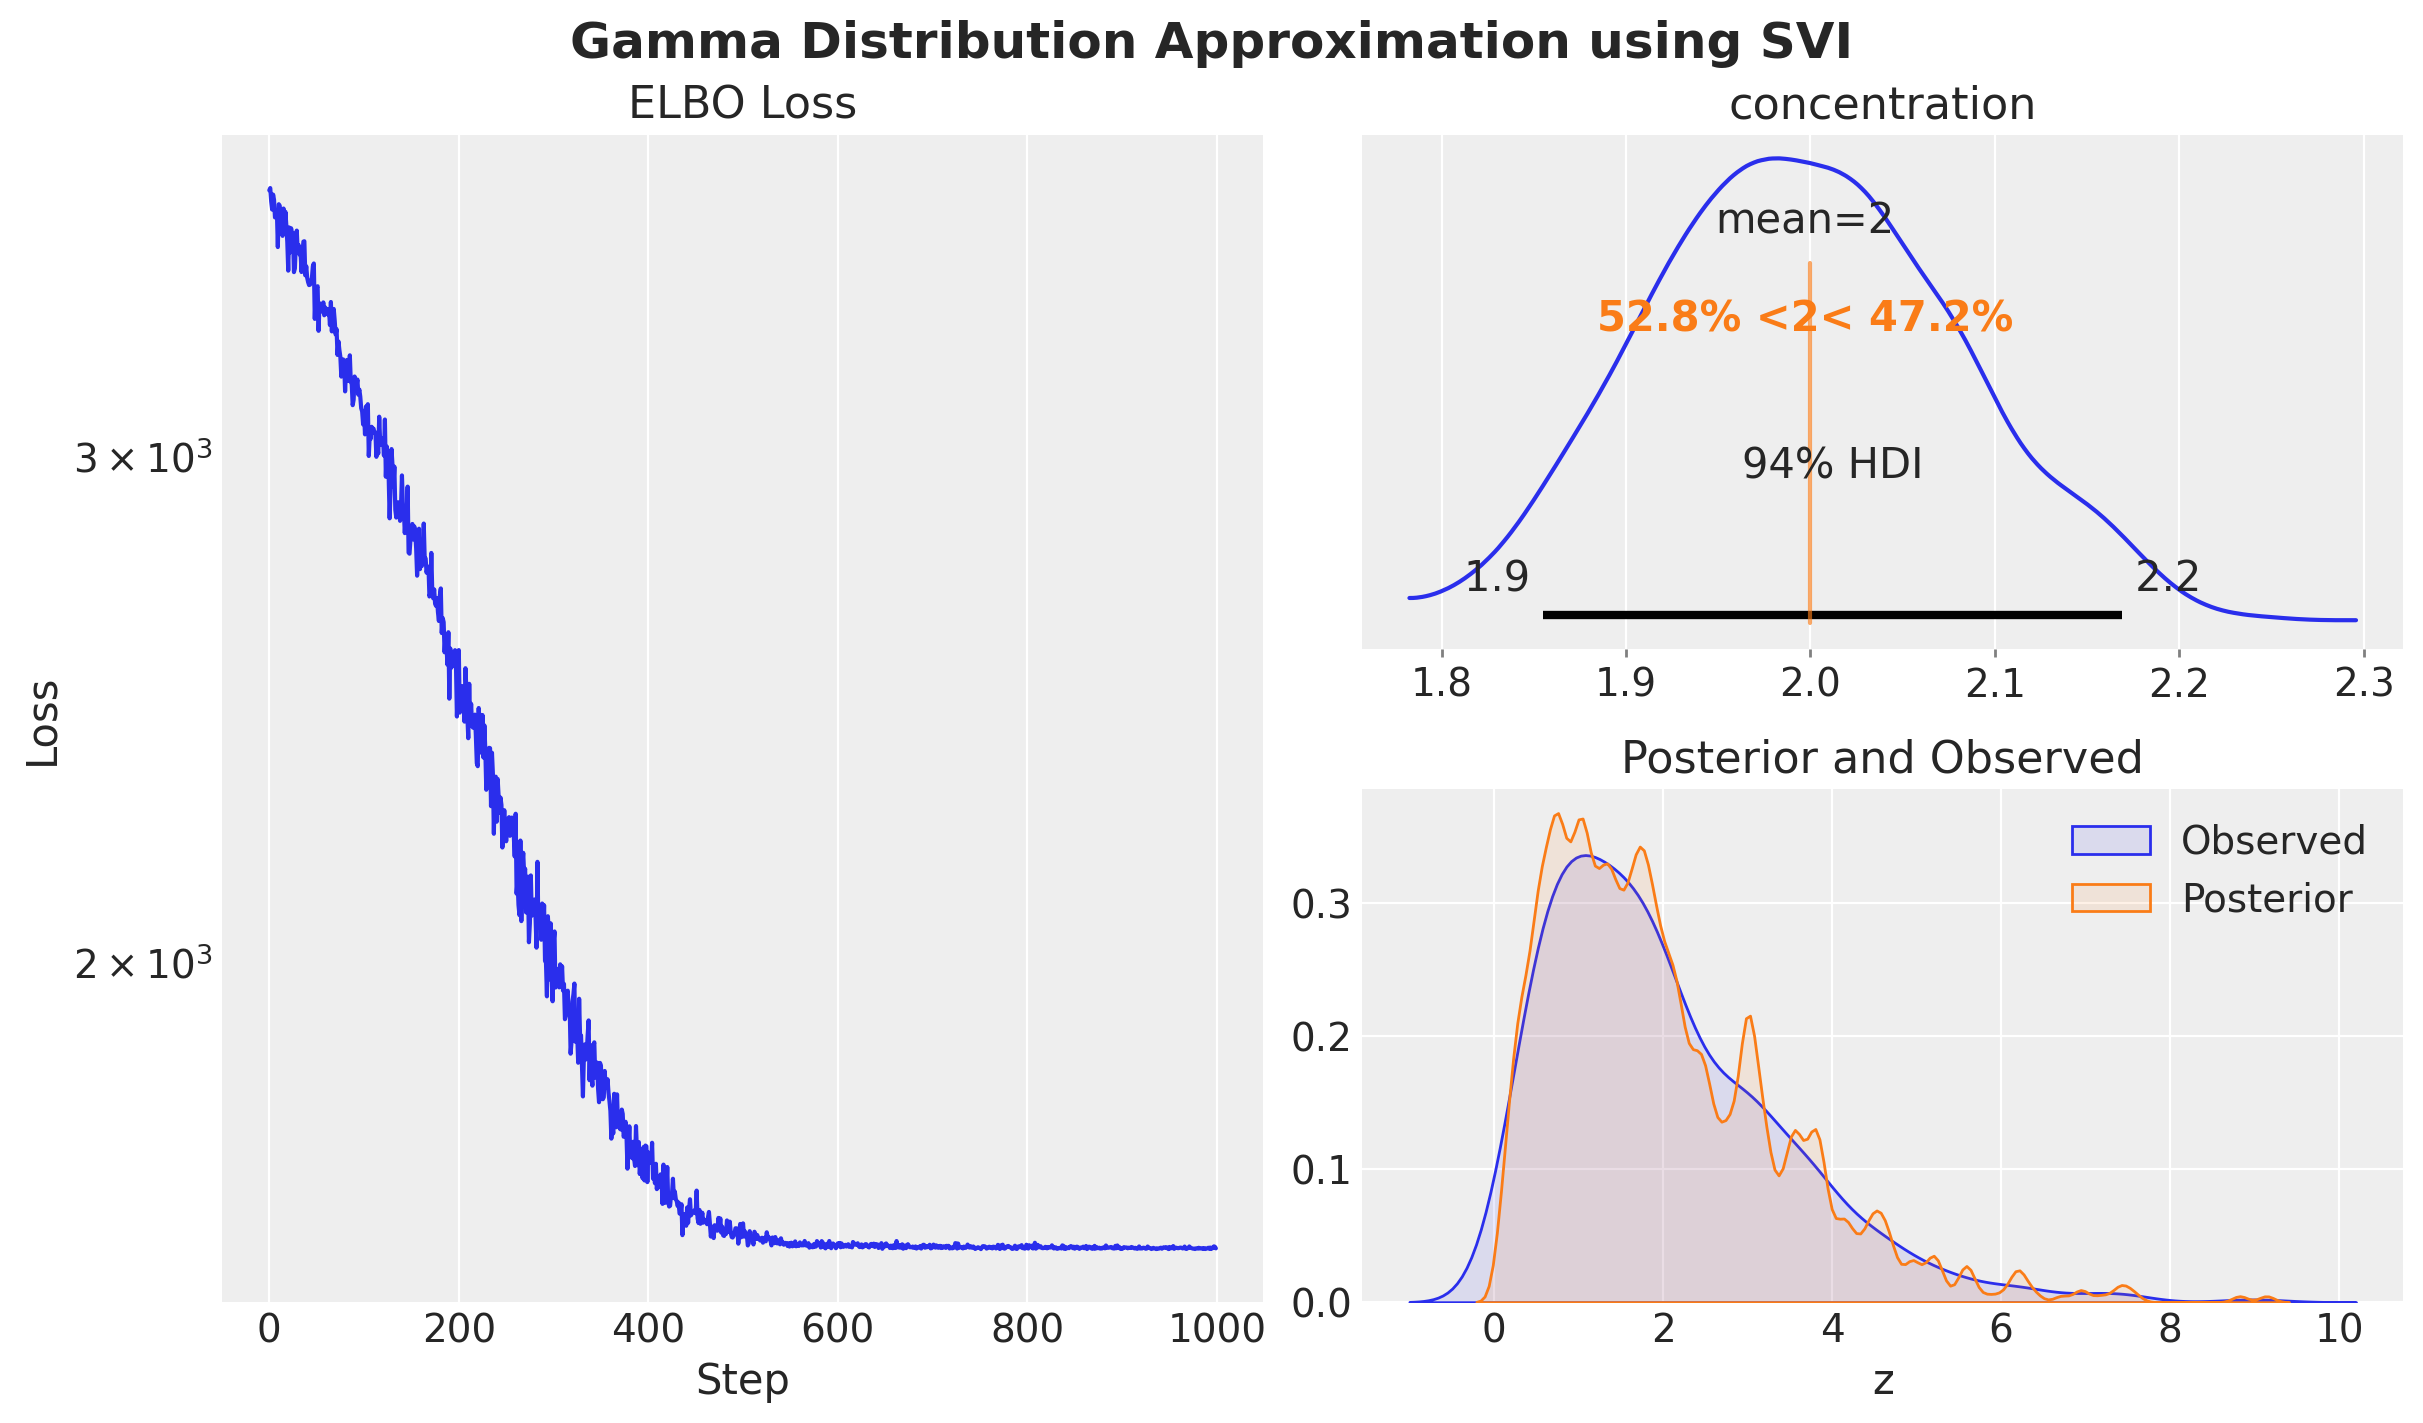

In [12]:
fig, axes = plt.subplot_mosaic(
    [["left", "upper right"], ["left", "lower right"]],
    figsize=(12, 7),
    layout="constrained",
)

axes["left"].plot(svi_result.losses)
axes["left"].set(yscale="log")
axes["left"].set(title="ELBO Loss", xlabel="Step", ylabel="Loss")
az.plot_posterior(
    idata, var_names=["concentration"], ref_val=concentration, ax=axes["upper right"]
)
sns.kdeplot(z, fill=True, alpha=0.1, label="Observed", ax=axes["lower right"])
sns.kdeplot(
    idata["posterior"]["z"].to_numpy().flatten(),
    color="C1",
    fill=True,
    alpha=0.1,
    label="Posterior",
    ax=axes["lower right"],
)
axes["lower right"].legend()
axes["lower right"].set(title="Posterior and Observed", xlabel="z", ylabel=None)
fig.suptitle(
    "Gamma Distribution Approximation using SVI", fontsize=18, fontweight="bold"
);

In [13]:
svi_result.params

{'concentration_auto_loc': Array(0.6895691, dtype=float32),
 'concentration_auto_scale': Array(0.04169116, dtype=float32)}